In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src/')
import wave_virulence as wv
import utils as ut
import plotter
import numba_functions as nbf
import numba as nb
from copy import deepcopy
from scipy.optimize import brentq

import pickle

In [2]:
def build_assay_wave(id_, r0, D, beta0, alphas, stoch=False, gamma=0.5, cutoff=1, time=1000, eps=1e-5, global_cutoff=True):
    dx = ut.lin_from_two_log_points(r0/Delta_x, 0.5, 0.1, 100, 1)
    dt = ut.dt_from_cfl(0.02, D, dx)

    p = wv.Vwave_virulence_pars(id_, tot_time=time, dt=dt, dx=dx, 
                     n_x_bins=int( ut.lin_from_two_points(r0/Delta_x, 0.5, 200, 50, 5000)/dx ), 
                     M=5, r0=r0, D_coef=D, beta=beta0, gamma=gamma, n_alpha_bins=len(alphas),
                     alphas=alphas, eps=eps,
                     Nh=10**10, N0=10**8, cutoff=cutoff,
                     t_burn=ut.lin_from_two_points(r0/Delta_x, 0.5, 10000, 50, 500000), 
                     t_burn_cutoff=ut.lin_from_two_points(r0/Delta_x, 0.5, 200, 50, 10000), 
                     back_width_fract=ut.lin_from_two_log_points(r0/Delta_x, 0.5, 0.5, 50, 3),
                     traj_step=int(50/dt), check_step=0, traj_after_burn=True, verbose=True, global_cutoff=global_cutoff)
    
    return deepcopy(wv.Vwave_virulence(p, stoch))


class eps_schedule():
    """
    Scheduling of the diffusion coefficient over the mutation rate
    """
    
    def __init__(self, first_eps, first_time, decay_exp, decay_scale):
        self.first_eps = first_eps
        self.first_time = first_time
        self.decay_exp = decay_exp
        self.decay_scale = decay_scale
        
    def get(self, t):
        if t < self.first_time:
            return self.first_eps
        else:
            t1 = t - self.first_time
            return self.first_eps*( self.decay_scale/(t1 + self.decay_scale) )**self.decay_exp


## r0 scan

In [38]:
Delta_x = 1
c_list = np.logspace(np.log10(0.5), np.log10(100), 20)
D_coef = 0.5e-3 * Delta_x**2
r0_list = c_list * Delta_x

gamma = 0.05
beta0 = 0.5
stoch, cutoff = False, 1
n_alpha_bins = 50
time = 60000
eps = eps_schedule(2e-9, time/4, 2, time/4)
alphas = np.linspace(0, 0.1, n_alpha_bins)

In [ ]:
assays = []
for i, r0 in enumerate(r0_list):
    assays.append(build_assay_wave(i, r0, D_coef, beta0, alphas, stoch, gamma, cutoff, time=time, global_cutoff=True, eps=eps))

In [17]:
# saving the assays in a file 
f = open('data/virulence_assays_Dx=%g.pickle'%Delta_x, 'wb')
pickle.dump(waves, f)
f.close()

In [41]:
# importing the assays without running everything again
f = open('data/virulence_assays_Dx=%g.pickle'%Delta_x, 'rb')
waves = pickle.load(f)
f.close()

In [42]:
def a_lin_f(p, a):
    _s = sel_coef_lin(p, a)
    k = -2.3381 * (p.D_coef*_s**2)**(1/3)
    _N_lin = size_lin(p, a)
    _v_lin = speed_lin(p, _N_lin, a)
    return _v_lin**2/4/d - a + g - k/3

def vtau_lin(p, a):
    return p.r0*((p.beta*np.sqrt(a)/(a + p.gamma))**(1/p.M) - 1)**(-1)

def sel_coef_lin(p, a):
    return (a + p.gamma)*p.M/vtau_lin(p, a)

def speed_lin(p, size, a):
    s = sel_coef_lin(p, a)
    d_inv = (s/p.D_coef)**(1/3)
    eps0 = - 2.3381
    r = size/cutoff
    aux = 3*np.log(r*d_inv)
    return 2*p.D_coef*d_inv*(aux**(1/3) + eps0*aux**(-1/3))

def size_lin(p, a):
    vtau = vtau_lin(p, a)
    def _Neq(x, p, vtau):
        return (vtau - speed_lin(p, x, a)*p.M*p.Nh/x)
    return brentq(_Neq, 1e4, p.Nh*1000, args = (p, vtau))

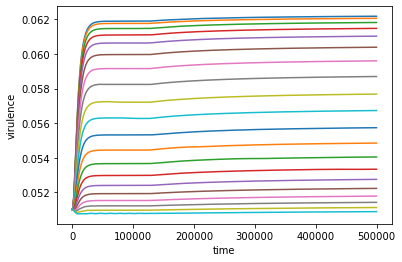

In [43]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel('time')
ax.set_ylabel('virulence')

mean_alphas, max_alphas = [], []
speeds, f_tips, s_tips = np.array([]), np.array([]), np.array([])
est, est_FKPP, est_lin = np.array([]), np.array([]), np.array([])
r0_lin_start = 10

for w in waves:
    speeds = np.append(speeds, np.mean(w.traj.speed(3)[-100:]))
    f_tips = np.append(f_tips, np.mean(w.traj.f_tip[-20:]))
    s_tips = np.append(s_tips, np.mean(w.traj.s_tip[-20:]))
    mean_alphas.append(w.traj.mean_alpha[-1]),
    max_alphas.append(w.traj.max_alpha[-1])
    ax.plot(w.traj.times - w.p.t_burn, w.traj.mean_alpha)
    
    a, g, b, d = w.p.alpha, w.p.gamma, w.p.beta, w.p.D_coef
    v, f, s = speeds[-1], f_tips[-1], s_tips[-1]
    k = -2.3381 * (d*s**2)**(1/3)
    
    est = np.append(est, f + g + 2/3*k)
    est_FKPP = np.append(est_FKPP, b**2/4)
    
    _a_lin_f = lambda a : a_lin_f(w.p, a)
    if w.p.r0 > r0_lin_start:
        est_lin = np.append(est_lin, brentq(_a_lin_f, 0.05, 0.07))
    else:
        est_lin = np.append(est_lin, 0)
    

Text(0, 0.5, '$\\alpha_{ES}$')

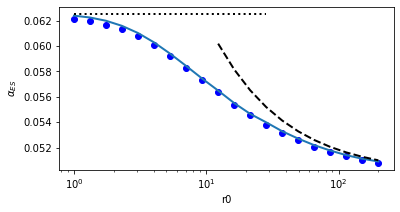

In [25]:
plt.figure(figsize=(6,3))
plt.xscale('log')
plt.scatter(r0_list, mean_alphas, c='b', label='average alpha')

#est1 = speeds**2/4/D_coef + gamma
#est2 = speeds**2/4/D_coef + gamma + 2.3381/3*(D_coef*s_tips**2)**(1/3) 
plt.plot(r0_list, est, lw=2)

i_FKPP_end = 13
i_lin_start = np.sum(r0_list<r0_lin_start)
plt.plot(r0_list[:i_FKPP_end], est_FKPP[:i_FKPP_end], c='k', ls=':', lw=2)
plt.plot(r0_list[i_lin_start:], est_lin[i_lin_start:], c='k', ls='--', lw=2)

plt.xlabel('r0')
plt.ylabel(r'$\alpha_{ES}$')

#plt.savefig('es_virulence_global_cutoff.svg', dpi=200)

In [26]:
f = open('data/ES_virulence_Dx=%g.tsv'%Delta_x, 'w')

header = '#r0\talpha_ES\talpha_ES_tip\tF_T\ts_T\talpha_ES_FKPP\talpha_ES_linfit\n'
f.write(header)

for i in range(len(r0_list)):
    f.write(str(r0_list[i]) + '\t')
    f.write(str(mean_alphas[i]) + '\t')
    f.write(str(est[i]) + '\t')
    f.write(str(f_tips[i]) + '\t')
    f.write(str(s_tips[i]) + '\t')
    f.write(str(est_FKPP[i]) + '\t')
    f.write(str(est_lin[i]) + '\t')
    
    f.write('\n')
    
f.close()


f = open('data/ES_virulence_pars_Dx=%g.tsv'%Delta_x, 'w')

header = '#parameter\tvalue\n'
f.write(header)

f.write('D\t' + str(waves[0].p.D_coef) + '\n')
f.write('b\t' + str(waves[0].p.beta) + '\n')
f.write('gamma\t' + str(waves[0].p.gamma) + '\n')
f.write('Nh\t' + str(waves[0].p.Nh) + '\n')
f.write('M\t' + str(waves[0].p.M) + '\n')
f.write('cutoff\t' + str(waves[0].p.cutoff) + '\n')

f.close()